In [1]:
import pandas as pd

# Load dataset (assumes you have the CSV downloaded)
df = pd.read_csv('StudentsPerformance.csv')
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


In [2]:
from scipy.stats import ttest_ind

# Split into two groups
group_completed = df[df['test preparation course'] == 'completed']['math score']
group_none = df[df['test preparation course'] == 'none']['math score']

# Perform t-test
t_stat, p_val = ttest_ind(group_completed, group_none)

t_stat, p_val


(np.float64(5.704616417349102), np.float64(1.5359134607147415e-08))

In [3]:
print(f"T-statistic: {t_stat:.3f}, P-value: {p_val:.3f}")

T-statistic: 5.705, P-value: 0.000


In [4]:
from scipy.stats import shapiro, levene

print("Shapiro Test - Completed:", shapiro(group_completed))
print("Shapiro Test - None:", shapiro(group_none))
print("Levene’s Test for equal variances:", levene(group_completed, group_none))

Shapiro Test - Completed: ShapiroResult(statistic=np.float64(0.9936613643190316), pvalue=np.float64(0.13934941590125344))
Shapiro Test - None: ShapiroResult(statistic=np.float64(0.9921171200614826), pvalue=np.float64(0.0017542243871878584))
Levene’s Test for equal variances: LeveneResult(statistic=np.float64(0.5330170705114402), pvalue=np.float64(0.4655125071689348))


# ## for understanding
# ### shapiro-Wilk Test (shapiro):
# Used to check if the data is normally distributed (i.e., bell-shaped curve).
#
# Why? Because a t-test assumes normality in the distribution of the two groups.
#
# Each call here checks normality of math scores for:
#
# Students who completed the test prep
#
# Students who did not complete the test prep
#
# | Test        | Purpose                  | Assumption Tested                      | p-value Meaning   |
# | ----------- | ------------------------ | -------------------------------------- | ----------------- |
# | `shapiro()` | Normality                | Data should be normally distributed    | p > 0.05 → Normal |
# | `levene()`  | Homogeneity of variances | Both groups should have equal variance | p > 0.05 → Equal  |
#

In [5]:
if p_val < 0.05:
    print("Reject the null hypothesis: Prep course significantly affects math scores.")
else:
    print("Fail to reject the null: No significant difference in math scores.")

Reject the null hypothesis: Prep course significantly affects math scores.


In [6]:
# Compute correlation matrix
correlation_matrix = df[['math score', 'reading score', 'writing score']].corr()
correlation_matrix

,math score,reading score,writing score
math score,1.000000,0.817580,0.802642
reading score,0.817580,1.000000,0.954598
writing score,0.802642,0.954598,1.000000


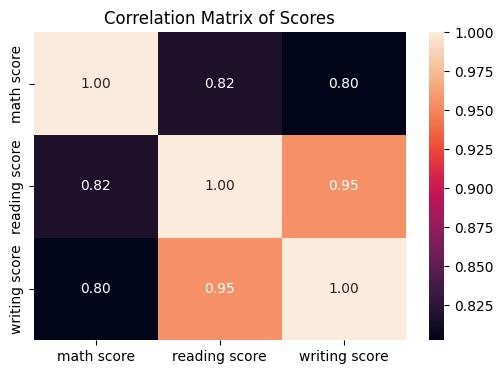

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='rocket', fmt=".2f")
plt.title("Correlation Matrix of Scores")
plt.show()

In [8]:
# Find strongest positive correlation (excluding self-correlation)
corr_pairs = correlation_matrix.unstack()
strongest_corr = corr_pairs[corr_pairs != 1.0].sort_values(ascending=False).head(1)
strongest_corr

,,0
writing score,reading score,0.954598


# corr_pairs != 1.0: Removes self-correlations (e.g., math with math = 1.0)
#
# .sort_values(ascending=False): Sorts the remaining pairs by correlation strength (highest first)
#
# .head(1): Picks the strongest positive correlation (top one)
#
#


In [9]:
import statsmodels.formula.api as smf

# Encode categorical variable
df['test_prep_encoded'] = df['test preparation course'].map({'none': 0, 'completed': 1})

# Fit the model
model = smf.ols('Q("math score") ~ Q("reading score") + test_prep_encoded', data=df).fit()

# Show model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Q("math score")   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     1007.
Date:                Thu, 22 May 2025   Prob (F-statistic):          5.32e-240
Time:                        16:53:39   Log-Likelihood:                -3584.7
No. Observations:                1000   AIC:                             7175.
Df Residuals:                     997   BIC:                             7190.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              7.2292      1

# ## Interpret the meaning of at least one predictor coefficient in context:
# reading score:
# Holding test preparation constant, students with higher reading scores tend to also have higher math scores. Specifically, each additional point in reading score is associated with a 0.85-point increase in math score on average, and this relationship is highly statistically significant (p < 0.001).

# The R-squared value is 0.669, which means that about 66.9% of the changes in math scores can be explained by reading scores and whether the student took the test preparation course.
#
# Also, the F-statistic is 1007 and the p-value is very small (less than 0.001). This tells us that the model is statistically significant.

# | Test / Metric             | Result     | Interpretation                                                                   |
# | ------------------------- | ---------- | -------------------------------------------------------------------------------- |
# | **Durbin-Watson = 2.079** | Near 2     | Residuals are likely independent                                        |
# | **Omnibus & JB p-values** | > 0.05     | Residuals are **not significantly non-normal** → normality assumption is **met** |
# | **Skew / Kurtosis**       | Near 0 & 3 | Acceptable values                                                            |
#

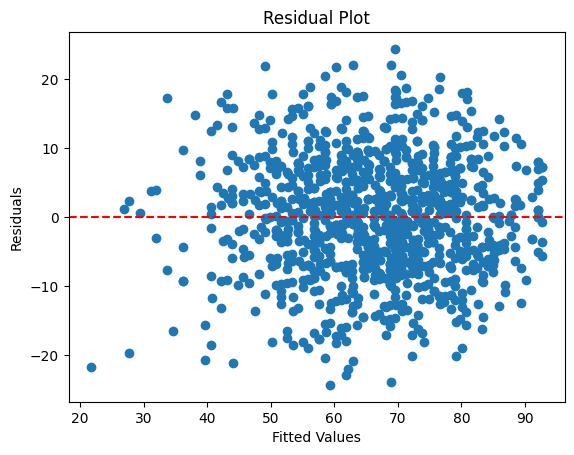

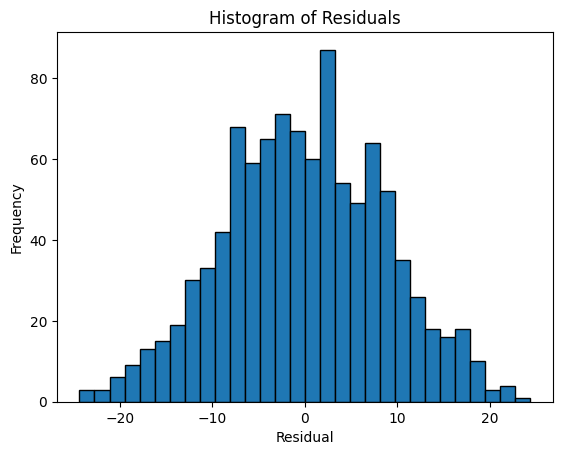

In [10]:
# Residual plot
import matplotlib.pyplot as plt

plt.scatter(model.fittedvalues, model.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# Histogram of residuals
plt.hist(model.resid, bins=30, edgecolor='k')
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()